In [5]:
import glob
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# READ FILES

In [30]:
glob.glob('..\ENERATIVA_F\*.*') #access to the data folder
file1 = '..\ENERATIVA_F\ENERATIVA_0103_18.xlsx'#Jan-Mar
#file1 = '..\ENERATIVA_F\ENERATIVA_0103_18_Original.xlsx'#Jan-Mar
file2 = '..\ENERATIVA_F\ENERATIVA_01_04_2018.xlsx' #Abril
file3 = '..\ENERATIVA_F\ENERATIVA_01_05_2018.xlsx' #Maio
file4 = '..\ENERATIVA_F\ENERATIVA_01-06_2018.xlsx'#Jun
file5 = '..\ENERATIVA_F\ENERATIVA_0312_18.xlsx'#Jul-Dec

xl = pd.ExcelFile(file1)
EA_0103 = xl.parse('Sheet1')

xl = pd.ExcelFile(file2)
EA_04 = xl.parse('Sheet1')

xl = pd.ExcelFile(file3)
EA_05 = xl.parse('Sheet1')

xl = pd.ExcelFile(file4)
EA_06 = xl.parse('Sheet1')

xl = pd.ExcelFile(file5)
EA_0712 = xl.parse('Sheet1') 
###########################################################3
# Assign spreadsheet filename to `file`
#file = 'WEATHERDATA.xlsx'
file = '..\ENERATIVA_F\Weather\WEATHERdata.xlsx'
# Load spreadsheet
xl = pd.ExcelFile(file)

# Print the sheet names
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
weather = xl.parse('Sheet1')

['Sheet1']


# <font color=brown>Functions Section</font>

## Data Clean, Index, and Fix column names  
1. The first three rows don't contain data 
2. The last three rows don't contain data
3. Make Date column in index
4. Fix the name of columns
5. Delete rows where Tag_Name is nan

In [19]:
# Function to Pre-Clean the data
def preclean(df):
    df.drop(df.head(3).index,inplace=True)                   # Drop the first three rows
    df=df[:-3]                                               # Drop the last three rows
    df = df.set_index(['Date'])                              # Transform Date column in index        
    df.index.name = None
    df.columns = df.columns.str.replace(' ', '_')            # Fix Column name: Fill spaces with _
    df['Value'] = pd.to_numeric(df.Value, errors='coerce')   # Convert Value column to float
    df = df[pd.notnull(df['Tag_Name'])]                      # Delete rows where Tag_Name is nan
    return df;

## Function: drop the columns with unique values equal to ONE

In [20]:
def dropUniqueOne(dataset):
    xx=dataset.nunique()                           # Extract the information of the unique value for each colunm
    xx = pd.DataFrame(xx)                          # Transform in a DataFrame
    ColName= xx.index.values[xx[0] == 1]           # Take the name of the columns with unique value equal ONE
    dataset = dataset.drop(ColName, axis=1)        # Make a DataFrame with only the columns with more than one unique value
    return dataset;

# <font color=brown>MAIN CODE</font>

##  <font color=green>Energy</font>

## Preclean

In [31]:
# Merge the two Datasets
df1=preclean(EA_0103)
df2=preclean(EA_04)
df3=preclean(EA_05)
df4=preclean(EA_06)
df5=preclean(EA_0712)
df =pd.concat([df1,df2,df3,df4,df5])

## Energy Files: Identify the distinct Ciurcuit and Consumption Types

In [32]:
# Drop Columns with only one distinct value
df = dropUniqueOne(df)
energy = df
energy.Circuit.unique()
energy.Consumption.unique()

### Mount datasets for each Circuit type

In [41]:
AVAC_P1Par = energy[energy['Value'].notnull() & (energy['Circuit'] == "AVAC - Piso 1") & (energy['Consumption'] == "Partial")]
AVAC_RCPar = energy[energy['Value'].notnull() & (energy['Circuit'] == "AVAC - R/C") & (energy['Consumption'] == "Partial")]
GerAgg = energy[energy['Value'].notnull() & (energy['Circuit'] == "Geral") & (energy['Consumption'] == "Aggregated")]

In [52]:
test = pd.merge(AVAC_RCPar, AVAC_P1Par, right_index=True, left_index=True)
test.columns = ['AvacRC', 'ConsumptionRC','CircuitRC', 'AvacPiso1','ConsumptionPiso1','CircuitPiso1']
test2= pd.merge(test, GerAgg, right_index=True, left_index=True)
energyAll = test2
energyAll.rename(columns={'Value':'Geral',
                          'Consumption':'ConsumptionGer',
                          'Circuit':'CircuitGer'}, 
                 inplace=True)

# <font color=green>Weather</font>

## Preclean

In [54]:
weather = preclean(weather)

## Mount different dataset for each tag_name

In [56]:
df = dropUniqueOne(weather)

In [60]:
df.Tag_Name.unique()

array(['Humidity', 'Temperature'], dtype=object)

In [66]:
temperature = df["Tag_Name"] == "Temperature"
temperature = df[temperature]

humidity = df["Tag_Name"] == "Humidity"
humidity = df[humidity]

## Merge humidity and temperature

In [68]:
humtemp = pd.merge(humidity,temperature,right_index=True, left_index=True)
humtemp.columns = ['TagHum', 'Humidity','TagTemp', 'Temperature']

# Calculate Heating Degree Days and Cooling Degree Days
- Heating = 15
   - If temperature is less or equal to 15ºC we need to heat the room for it take a 18ºc of temperature So HDD = 18-Text if Text<= 15ºC otherwhise HDD = 0
- Cooling= 18
   - If temperature is higher or equal to 24ºC we need to cool the room for it take a 21ºC of temperature So CDD = Text-21 if Text>= 24ºC otherwhise CDD = 0

In [147]:
HDD = map(lambda x: 18-x if x<=15 else 0, humtemp['Temperature'])  
CDD = map(lambda x: x-21 if x>=24 else 0, humtemp['Temperature'])  
humtemp['HDD'] = list(HDD)
humtemp['CDD'] = list(CDD)

In [148]:
humtemp.head()

,TagHum,Humidity,TagTemp,Temperature,HDD,CDD
2018-01-01 00:00:00,Humidity,95.00000,Temperature,7.85000,10.15000,0.0
2018-01-01 01:00:00,Humidity,94.66667,Temperature,7.63333,10.36667,0.0
2018-01-01 02:00:00,Humidity,95.00000,Temperature,7.37500,10.62500,0.0
2018-01-01 03:00:00,Humidity,95.00000,Temperature,7.40000,10.60000,0.0
2018-01-01 04:00:00,Humidity,94.75000,Temperature,7.30000,10.70000,0.0


# <font color=green>Energy and Weather together </font>
- Energy [kWh]
- Humidity [%]
- Temperature [ºC]

In [149]:
energyweather=pd.merge(energyAll, humtemp, right_index=True, left_index=True)

In [150]:
energyweather.head()

,AvacRC,ConsumptionRC,CircuitRC,AvacPiso1,ConsumptionPiso1,CircuitPiso1,Geral,ConsumptionGer,CircuitGer,TagHum,Humidity,TagTemp,Temperature,HDD,CDD
2018-01-01 00:00:00,1.6,Partial,AVAC - R/C,0.2,Partial,AVAC - Piso 1,3.7,Aggregated,Geral,Humidity,95.00000,Temperature,7.85000,10.15000,0.0
2018-01-01 01:00:00,1.5,Partial,AVAC - R/C,0.3,Partial,AVAC - Piso 1,3.8,Aggregated,Geral,Humidity,94.66667,Temperature,7.63333,10.36667,0.0
2018-01-01 02:00:00,1.5,Partial,AVAC - R/C,0.3,Partial,AVAC - Piso 1,3.7,Aggregated,Geral,Humidity,95.00000,Temperature,7.37500,10.62500,0.0
2018-01-01 03:00:00,1.5,Partial,AVAC - R/C,0.3,Partial,AVAC - Piso 1,3.8,Aggregated,Geral,Humidity,95.00000,Temperature,7.40000,10.60000,0.0
2018-01-01 04:00:00,1.5,Partial,AVAC - R/C,0.3,Partial,AVAC - Piso 1,3.7,Aggregated,Geral,Humidity,94.75000,Temperature,7.30000,10.70000,0.0


# Correlation plot

In [151]:
#select columns of dataframe
corrplot= energyweather[['AvacRC','AvacPiso1','Geral','Humidity','Temperature', 'HDD', 'CDD']]

In [152]:
correlations = corrplot.corr()

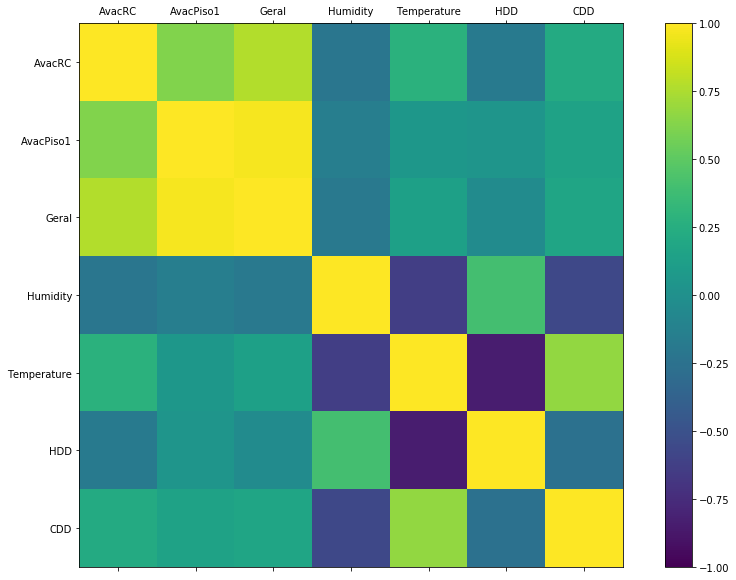

In [154]:
names = ['AvacRC','AvacPiso1','Geral','Humidity','Temperature','HDD', 'CDD']
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

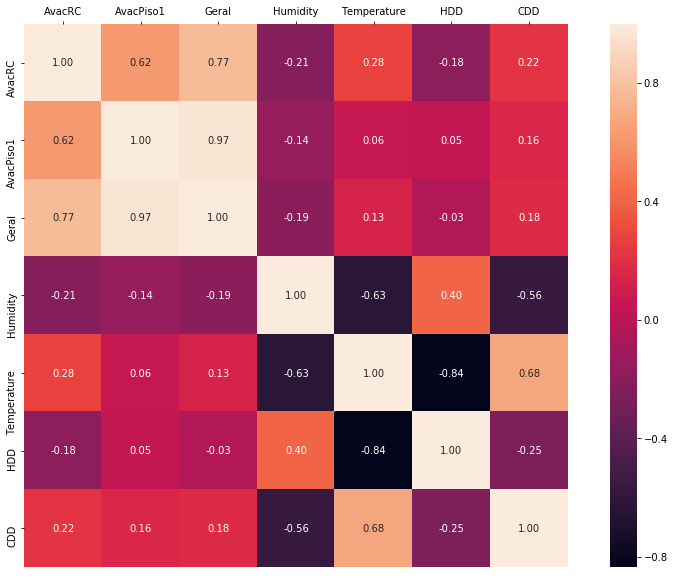

In [155]:
plt.figure(figsize=(15,10))
sns.heatmap(correlations, vmax=1., square=True, annot=True, fmt=".2f").xaxis.tick_top()

## Treatment of Negative Values

In [83]:
energyweather.columns.tolist()[1:]

['ConsumptionRC',
 'CircuitRC',
 'AvacPiso1',
 'ConsumptionPiso1',
 'CircuitPiso1',
 'Geral',
 'ConsumptionGer',
 'CircuitGer',
 'TagHum',
 'Humidity',
 'TagTemp',
 'Temperature']

In [89]:
types = energyweather.dtypes 

In [105]:
for col in types[types == 'float64'].index:
    data = energyweather.loc[energyweather[col] < 0]
    data

In [114]:
tt = energyweather.describe().loc['min'] 
tt1 = tt[tt<0]

In [126]:
tt1.loc.list()

AttributeError: '_LocIndexer' object has no attribute 'list'